In [1]:
!pip install transformers tensorflow
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

X_train, X_val, y_train, y_val = train_test_split(df_train['text'], df_train['target'], test_size=0.2, random_state=42)
X_test = df_test['text']

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts):
    return tokenizer(texts.to_list(), padding=True, truncation=True, max_length=128, return_tensors="tf")

X_train_enc = encode_texts(X_train)
X_val_enc = encode_texts(X_val)
X_test_enc = encode_texts(X_test)

In [3]:
# Prepare the TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(X_train_enc), y_train)).shuffle(1000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(X_val_enc), y_val)).batch(32)

# Load the pre-trained BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
191/191 [==============================] - 3492s 18s/step - loss: 0.4454 - accuracy: 0.7997 - val_loss: 0.3962 - val_accuracy: 0.8365
Epoch 2/3
191/191 [==============================] - 2989s 16s/step - loss: 0.3048 - accuracy: 0.8814 - val_loss: 0.4004 - val_accuracy: 0.8319
Epoch 3/3
191/191 [==============================] - 2946s 15s/step - loss: 0.1897 - accuracy: 0.9333 - val_loss: 0.5334 - val_accuracy: 0.7945


In [11]:
# Prepare the TensorFlow dataset for the test data (features only)
test_dataset = tf.data.Dataset.from_tensor_slices(dict(X_test_enc)).batch(32)

# Make predictions on the test data
predictions = model.predict(test_dataset)

# Convert these to probabilities:
probabilities = tf.nn.softmax(predictions.logits).numpy()

# Determine the class predictions
predicted_classes = tf.argmax(probabilities, axis=1)
print("Predictions:", predicted_classes)


102/102 [==============================] - 508s 5s/step
Predictions: tf.Tensor([1 1 1 ... 1 1 1], shape=(3263,), dtype=int64)


In [14]:
import numpy as np

# Convert TensorFlow tensor to numpy array for analysis
predicted_classes_array = predicted_classes.numpy()

# Distribution of the predicted classes
unique, counts = np.unique(predicted_classes_array, return_counts=True)
distribution = dict(zip(unique, counts))
print("Prediction Distribution:", distribution)

Prediction Distribution: {0: 1755, 1: 1508}


In [17]:
# Define sample_indices as random indices from test dataset
sample_indices = np.random.choice(len(predicted_classes_array), 10, replace=False)  # Sample 10 indices without replacement

# Using indices to print text, predicted class, and probability
for i in sample_indices:
    print(f"Text: {df_test['text'].iloc[i]}\nPredicted Class: {predicted_classes_array[i]}, Probability: {max_probabilities[i]:.4f}\n")

Text: Madhya Pradesh Train Derailment: Village Youth Saved Many Lives: A group of villagers saved over 70 passengers' lives after two train...
Predicted Class: 1, Probability: 0.9987

Text: You know it's hot when there are bush fires right near your villa ????
Predicted Class: 1, Probability: 0.9731

Text: Drought report lists SE Texas as 'abnormally dry' http://t.co/wBOXpyoZj0 #SETXNews
Predicted Class: 1, Probability: 0.9976

Text: Do you feel deluged by unhappiness? Take the quiz: http://t.co/blBVVpbw2z http://t.co/05qooc9CbR
Predicted Class: 0, Probability: 0.9722

Text: #LegalJobs Litigation Attorney in Scottsdale AZ:  Claims Specialist II Casualty Bodily Injury 
The can... http://t.co/zqrQEg3Cxl #Jobs
Predicted Class: 1, Probability: 0.6356

Text: No don't tell me that!
Predicted Class: 0, Probability: 0.9825

Text: British trekkers rescued amid flash floods in Himalayas - BBC News
Predicted Class: 1, Probability: 0.9972

Text: SPD OFFICER SHOT - PLEASE PRAY

Please pray for the 

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

# Predict probabilities for the validation set
val_pred = model.predict(val_dataset)
val_logits = val_pred.logits
val_probs = tf.nn.softmax(val_logits, axis=-1)[:, 1].numpy()  # Probabilities for the positive class

# Extract the true labels from the validation dataset
true_val_labels = np.concatenate([y for x, y in val_dataset], axis=0)

# Calculate the F1 score
val_preds = np.argmax(val_logits, axis=1)
f1 = f1_score(true_val_labels, val_preds)
print(f'F1 score: {f1}')

48/48 [==============================] - 166s 3s/step
F1 score: 0.7690036900369004


2024-04-29 23:35:50.476486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Confusion Matrix:
[[689 185]
 [128 521]]


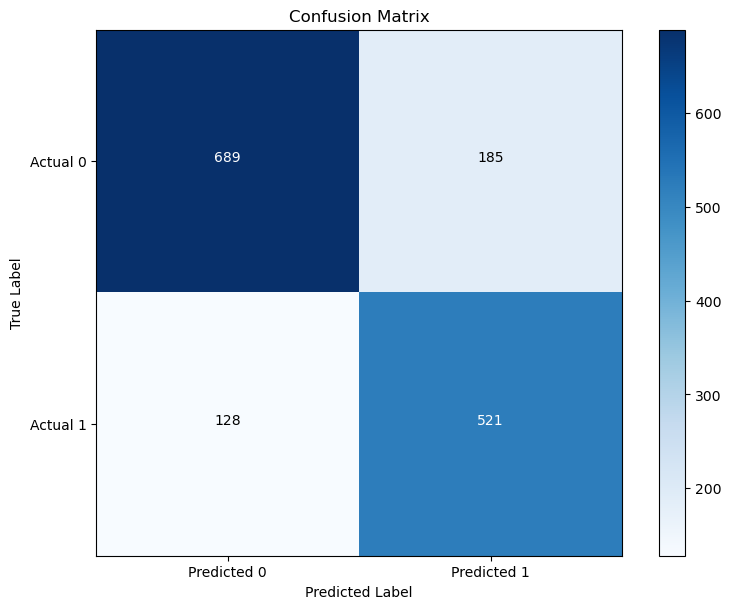

In [28]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_val_labels, val_preds)
print(f'Confusion Matrix:\n{conf_matrix}')

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted 0', 'Predicted 1'])
plt.yticks(tick_marks, ['Actual 0', 'Actual 1'])
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add annotations with white color for top left and bottom right squares
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text_color = "white" if i == j else "black"  # Set text color to white for top left and bottom right squares
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color=text_color)

plt.show()

ROC AUC: 0.8788084467214126


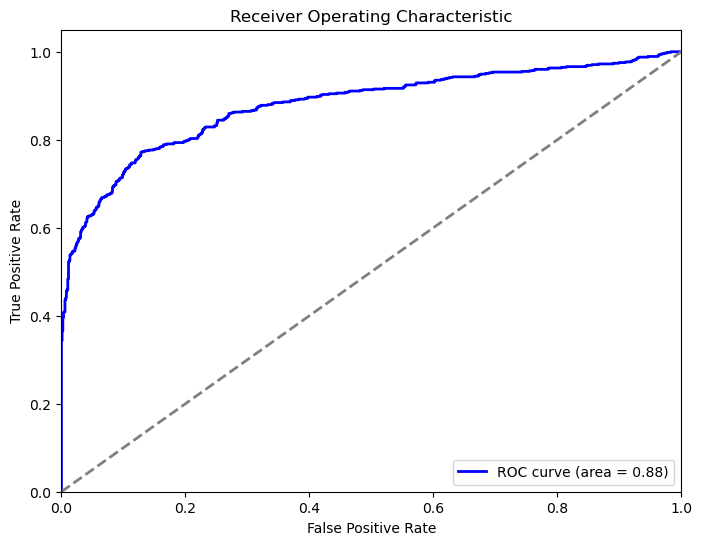

In [22]:
# Calculate ROC curve and AUC
fpr, tpr, roc_thresholds = roc_curve(true_val_labels, val_probs)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Precision-Recall AUC: 0.883396883557382


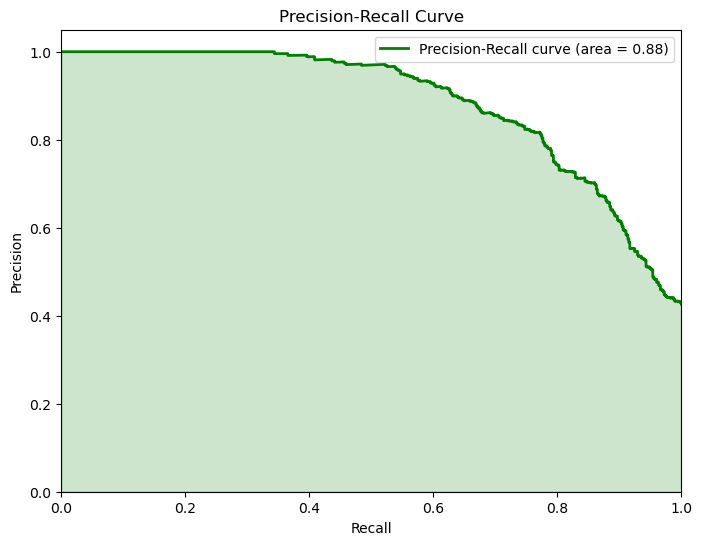

In [23]:
from tensorflow.keras.metrics import Precision, Recall

# Calculate precision-recall curve and AUC-PR
precision, recall, prc_thresholds = precision_recall_curve(true_val_labels, val_probs)
average_precision = average_precision_score(true_val_labels, val_probs)
print(f'Precision-Recall AUC: {average_precision}')

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()